In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display, Markdown
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data into pandas dataframes
topics_df = pd.read_csv('/content/drive/MyDrive/learning-equality-curriculum-recommendations/topics.csv', index_col=0).fillna({"title": "", "description": ""})
topics_df = topics_df[topics_df['language'] == 'en']
content_df = pd.read_csv('/content/drive/MyDrive/learning-equality-curriculum-recommendations/content.csv', index_col=0).fillna("")
content_df = content_df[content_df['language'] == 'en']
correlations_df = pd.read_csv('/content/drive/MyDrive/learning-equality-curriculum-recommendations/correlations.csv', index_col=0)

# Filter topics that have content
topics_df = topics_df[topics_df['has_content']]

In [ ]:
topics_df.head()

,title,description,channel,category,level,language,parent,has_content
id,,,,,,,,
t_00069b63a70a,Transcripts,,6e3ba4,source,3,en,t_4054df11a74e,True
t_0008a1bd84ba,12. 20: Bird Reproduction,,ebc86c,supplemental,5,en,t_c44ac9711007,True
t_000d1fb3f2f5,2.1.2 - Logarithms,,e77b55,aligned,5,en,t_b897d168db90,True
t_00102869fbcb,Triangles and polygons,Learning outcomes: students must be able to so...,a91e32,aligned,3,en,t_039cecc12bb8,True
t_0012a45fa09c,Quiz: materials and techniques,,2ee29d,aligned,4,en,t_6957d4a9f469,True


In [ ]:
# Define some helper functions and classes to aid with data traversal
def print_markdown(md):
    display(Markdown(md))

class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" >> ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"

class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

    def __eq__(self, other):
        if not isinstance(other, ContentItem):
            return False
        return self.id == other.id

    def get_all_breadcrumbs(self, separator=" >> ", include_root=True):
        breadcrumbs = []
        for topic in self.topics:
            new_breadcrumb = topic.get_breadcrumbs(separator=separator, include_root=include_root)
            if new_breadcrumb:
                new_breadcrumb = new_breadcrumb + separator + self.title
            else:
                new_breadcrumb = self.title
            breadcrumbs.append(new_breadcrumb)
        return breadcrumbs

In [ ]:
# Install necessary packages
!pip install annoy tqdm sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm.notebook import tqdm
from annoy import AnnoyIndex


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 31.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using ca

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# Initialize the sentence transformer model
model = SentenceTransformer("all-mpnet-base-v2")
# Using different models for comparison
# model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
# model = SentenceTransformer("all-MiniLM-L6-v2")
# model = SentenceTransformer("paraphrase-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Embedding topics
print("Embedding topics...")
topic_ids = topics_df.index
topic_embeddings = model.encode([f"{row['title']} - {row['description']}" for idx, row in topics_df.iterrows()])

# Embedding content
print("Embedding content...")
content_ids = content_df.index
content_embeddings = model.encode([row['title'] for idx, row in content_df.iterrows()])

Embedding topics...
Embedding content...


In [ ]:
# Prepare the data for training
X = np.vstack((topic_embeddings, content_embeddings))
y = np.concatenate((np.ones(len(topic_embeddings)), np.zeros(len(content_embeddings))))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Save the trained model to a file
joblib.dump(rf_model, 'random_forest_model.joblib')

# Load the trained model
rf_model = joblib.load('random_forest_model.joblib')

Accuracy: 0.8575456141284111
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91     13262
         1.0       0.94      0.55      0.70      5537

    accuracy                           0.86     18799
   macro avg       0.89      0.77      0.80     18799
weighted avg       0.87      0.86      0.84     18799

Confusion Matrix:
[[13057   205]
 [ 2473  3064]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 0.8575456141284111


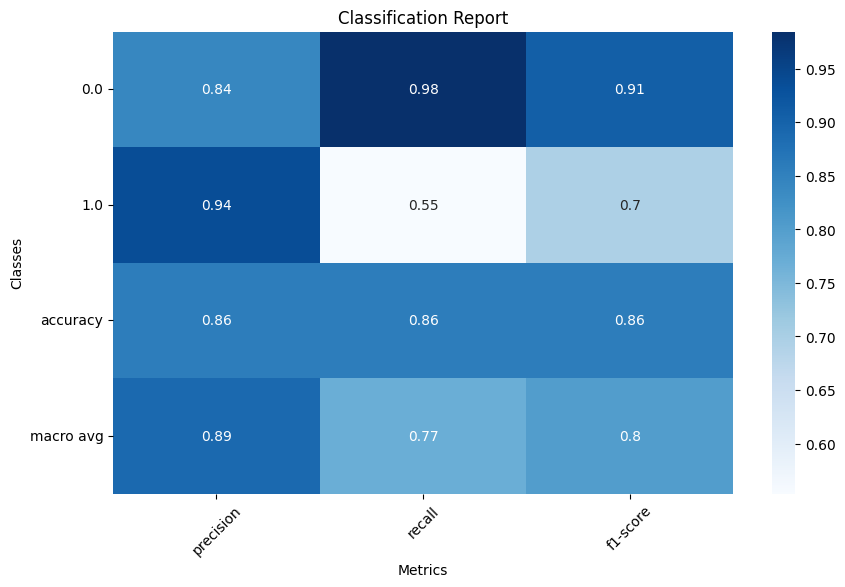

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')

# Convert evaluation results to tables
def plot_classification_report(report):
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Topic'], yticklabels=['Content', 'Topic'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# print(f'Accuracy: {accuracy}')
plot_classification_report(report_dict)


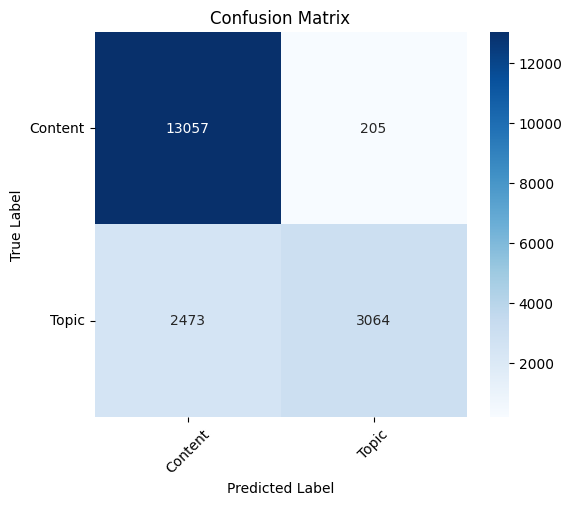

In [ ]:
plot_confusion_matrix(conf_matrix)

In [ ]:
class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    def get_breadcrumbs(self):
        topic = topics_df.loc[self.id]
        return f"{topic['title']} - {topic['description']}"

    @property
    def language(self):
        return topics_df.loc[self.id]['language']

# Define the recommend_content function
def recommend_content(topic_id, rf_model, model):
    # Get the embedding for the given topic_id
    topic_embedding = model.encode(f"{topics_df.loc[topic_id]['title']} - {topics_df.loc[topic_id]['description']}")

    # Calculate cosine similarities between the topic embedding and all content embeddings
    similarities = np.dot(content_embeddings, topic_embedding) / (np.linalg.norm(content_embeddings, axis=1) * np.linalg.norm(topic_embedding))

    # Get the indices of the highest similarity content
    top_indices = np.argsort(similarities)[-8:][::-1]  # Change the number 5 to however many recommendations you want

    # Map indices to content IDs
    recommended_content_ids = content_ids[top_indices]

    return recommended_content_ids

from tabulate import tabulate

# Assuming topics_df, content_df, content_embeddings, and content_ids are defined

def recommend(topic_id):
    recommended_content = recommend_content(topic_id, rf_model, model)
    if recommended_content is not None:
        print(f"Recommended content for Topic ID {topic_id}:")
        print("Topic title:", topics_df.loc[topic_id]["title"])
        headers = ["Content ID", "Title"]
        rows = []
        for content_id in recommended_content:
            rows.append([content_id, content_df.loc[content_id]['title']])
        print(tabulate(rows, headers=headers, tablefmt="pretty"))
    else:
        print(f"No recommendations available for Topic ID {topic_id}")

# Example usage:
# recommend(topic_id)

In [ ]:
topic_ids[0:50]

Index(['t_00069b63a70a', 't_0008a1bd84ba', 't_000d1fb3f2f5', 't_00102869fbcb',
       't_0012a45fa09c', 't_0016fa92caf4', 't_001a1575f24a', 't_001bd0fea51b',
       't_001d98bfb0c6', 't_001edc523bd1', 't_0020bde404c1', 't_00260f878951',
       't_0028ead4dc26', 't_002d1624e059', 't_002dfcaaf1d7', 't_002eec45174c',
       't_002f3fc3c840', 't_00328b0a7ccd', 't_0032c51bd677', 't_003761386023',
       't_00388edc1aff', 't_003964cfca42', 't_003bb2871126', 't_003cf02b4682',
       't_003f1d619141', 't_00437f5d7ce1', 't_0048851c9d8d', 't_004ec7f36178',
       't_00531bf01fb6', 't_00535b89fd1d', 't_0059e82958bd', 't_005b0b383f3f',
       't_005db937bae8', 't_005e4df86333', 't_006038bb5e62', 't_0062b3cbe9a6',
       't_0063126c08a8', 't_006447405435', 't_006550527831', 't_0065df081747',
       't_006659422dd8', 't_0066ce6cc9fe', 't_00679db553c5', 't_0068535bb628',
       't_00697daa2b18', 't_006c08bbf736', 't_006c65a14e6c', 't_007a41ee336d',
       't_007dc9b9459f', 't_007e3770673d'],
      dt

In [ ]:
# Example usage
recommend('t_00069b63a70a')  # Replace with an actual topic_id from your dataset

Recommended content for Topic ID t_00069b63a70a:
Topic title: Transcripts
+----------------+-----------------------------------------------------------------+
|   Content ID   |                              Title                              |
+----------------+-----------------------------------------------------------------+
| c_942b454ca508 |     Amount of Substance ..: Written Transcript part 2 of 2      |
| c_c4b6db8b5c7d |     Amount of Substance ..: Written Transcript part 1 of 2      |
| c_d0967bfa2fb2 |                2.8: Playgrounds and Transcripts                 |
| c_430ddb6fbfa4 |                          Transcription                          |
| c_07e16f3aabbf |                          Transcription                          |
| c_2359fa003e04 | Choosing a College R..: Written Transcript of this video lesson |
| c_89dee4e1d740 |                    Lecture 18: Transcription                    |
| c_fac629ee0e31 |                      Part 3: Transcription               

In [ ]:
recommend('t_001bd0fea51b')

Recommended content for Topic ID t_001bd0fea51b:
Topic title: Interest rates and the time value of money
Recommendations:
Content ID: c_aac0196fb179, Title: Mortgage interest rates
Content ID: c_00d7934678eb, Title: Relationship between bond prices and interest rates
Content ID: c_b0217c5c2966, Title: Nominal vs. real interest rates
Content ID: c_eb14dd36603a, Title: Calculation of Interest Coverage Ratio
Content ID: c_98e1860127ce, Title: Loan and Interest on Loan


In [ ]:
recommend('t_00328b0a7ccd')

Recommended content for Topic ID t_00328b0a7ccd:
Topic title: Electromagnet
Recommendations:
Content ID: c_9a324322bb7e, Title: Electromagnet
Content ID: c_4404aad7897a, Title: Electromagnets
Content ID: c_2ae028603ed4, Title: Electromagnetism
Content ID: c_e7330aed3bc2, Title: Electromagnetism
Content ID: c_9b9315e2d7c1, Title: Electromagnetic Spectrum


In [ ]:
recommend('t_00535b89fd1d')

Recommended content for Topic ID t_00535b89fd1d:
Topic title: 6. 26: Human Actions and the Sixth Mass Extinction
Recommendations:
Content ID: c_841e18f64fae, Title: 6. 26: Human Actions and the Sixth Mass Extinction
Content ID: c_3ba79a1a449e, Title: Human Actions and the Sixth Mass Extinction
Content ID: c_2c6bcad1eba5, Title: Human Actions and the Sixth Mass Extinction Practice
Content ID: c_b5007defab49, Title: 6.6: Moments and Centers of Mass
Content ID: c_82160b29e24e, Title: 6. 21: Human Population
